In [122]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from multiprocessing.pool import ThreadPool as Pool

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import redis
import time 
import seaborn as sns

from scipy.interpolate import interp1d
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from lifelines import KaplanMeierFitter
from collections import defaultdict

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_business.json', 'Dataset_Challenge_Dataset_Agreement.pdf', 'yelp_academic_dataset_user.json', 'yelp_academic_dataset_tip.json']


# Measuring the impact of negative Yelp reviews on businesses
Siddharth Garimella




I grew up in a neighborhood in which quite a few businesses came and went in the blink of an eye. Either they resonated with nearby residents, joining a select few other local mainstays, or they would swiftly be forced to close.

With the advent of online rating platforms such as Yelp, however, I believe the margin of error for many small businesses has decreased even further. Yelp is becoming an increasingly popular platform for prospective consumers to choose where to spend their money, and it is more and more important for many new businesses on Yelp to maintain a good average rating.

But what happens when the ratings are bad? Do bad average ratings early on in a company's Yelp page deter customers enough to make a measurable financial impact on the business? To answer these questions, I'm going to run a Survival Analysis using the Yelp academic dataset (easily downloaded from Kaggle's website, contains information about > 100k stores), and measure the times from the first Yelp review made for a store to the store's closure (if the store is closed).

### Loading Data

The data used for this project is the yelp academic dataset, publicly available on Kaggle here: https://www.kaggle.com/yelp-dataset/yelp-dataset. The dataset contains ~5.2M reviews about ~174k businesses, and is quite large. 

In [123]:
businesses = pd.read_json('../input/yelp_academic_dataset_business.json', lines = True)
businesses.drop(['address','attributes','city','hours','latitude','longitude','postal_code','state'],axis=1,inplace=True)


There are a ridiculous number of reviews in this dataset. Without reading the data in chunks, Pandas throws errors. For the sake of development initially, I'll just load a small fraction of the dataset, as running my algorithms on the entire dataset could likely take a lot of time.

In [124]:
def get_review_datachunk(n):
    reviews = pd.read_json('../input/yelp_academic_dataset_review.json', lines = True, chunksize=n);
    review_data = []
    clim = 1
    i = 0
    for chunk in reviews:
        if i < clim:
            review_data.append(chunk)
            i+=1
        else:
            break
    review_data[0].head(5)
    return review_data[0]

reviews = get_review_datachunk(150000);
reviews.drop(['cool','funny','review_id','text','useful','user_id'],axis=1,inplace=True)
len(reviews)

150000

### Understanding the data

I'll define what makes a "good" review and a "bad" review based on the review star count. This threshold is a bit arbitrary, but can provide some early insights about the data before further analysis. 

In [125]:
good_review_threshold = 4

businesses_good_reviews = businesses[businesses['stars'] >= good_review_threshold]
businesses_bad_reviews = businesses[businesses['stars'] < good_review_threshold]

The "is_open" column value is 1 if a business is open and 0 if a business is closed. This lets us easily determine how many businesses are open and closed.

In [126]:
businesses_good_reviews['is_open'].describe()

count    91486.000000
mean         0.850021
std          0.357053
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: is_open, dtype: float64

In [127]:
businesses_bad_reviews['is_open'].describe()

count    101123.000000
mean          0.798631
std           0.401025
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_open, dtype: float64

There are about five percent more closed businesses in the bad_reviews dataset thant the good_reviews one. I'll learn a little bit about the average number of reviews left at "good" and "bad" places next.

In [128]:
businesses_good_reviews['review_count'].describe()

count    91486.000000
mean        38.923639
std        129.525290
min          3.000000
25%          4.000000
50%          9.000000
75%         26.000000
max       8348.000000
Name: review_count, dtype: float64

In [129]:
businesses_bad_reviews['review_count'].describe()

count    101123.000000
mean         28.667445
std          88.745459
min           3.000000
25%           4.000000
50%           9.000000
75%          24.000000
max        6708.000000
Name: review_count, dtype: float64

It seems that places with good reviews have more reviews on average than places with bad reviews. 

### Analyzing the distribution of ratings

The stats from earlier were a bit vague, and there's a lot of information packed in there. To simplify things, I'll learn about the distribution of ratings by using a histogram.

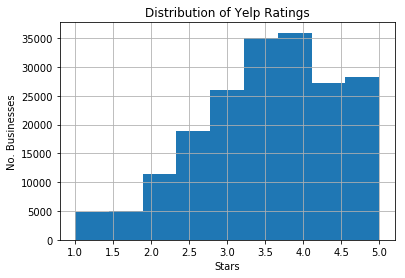

In [130]:
plt.figure();
dfs = businesses['stars'].sort_values();
dfs.hist(bins=9);
plt.xlabel('Stars');
plt.ylabel('No. Businesses');
plt.title('Distribution of Yelp Ratings');

Maybe a CDF of business ratings would be more useful here:

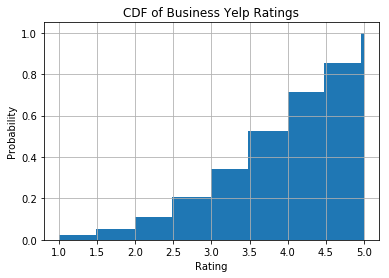

In [131]:
dfs.hist(cumulative=True, density=1, bins=100)
plt.xlabel('Rating');
plt.ylabel('Probability');
plt.title('CDF of Business Yelp Ratings');

### What businesss are being analyzed?

Knowing what businesses/industries compose the dataset will provide context for any measured negative impact due to reviews.

In [132]:
businesses['categories_top'] = businesses['categories'].apply(lambda x : (str(x).split(',')[0]).lower() )
#ax = sns.countplot(x="categories_top", data=businesses)
d = defaultdict(int)
for word in businesses['categories_top']:
    d[word] += 1
    
for key, value in sorted(d.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

restaurants: 17948
food: 8023
shopping: 7791
beauty & spas: 5832
home services: 5267
health & medical: 4570
automotive: 4130
local services: 3413
nightlife: 2713
active life: 2319
event planning & services: 2227
pizza: 2146
bars: 2132
hair salons: 2070
coffee & tea: 1976
fast food: 1937
sandwiches: 1808
auto repair: 1759
nail salons: 1734
hotels & travel: 1690
fashion: 1644
mexican: 1585
american (traditional): 1565
chinese: 1561
real estate: 1555
arts & entertainment: 1510
doctors: 1448
professional services: 1355
italian: 1335
pets: 1283
burgers: 1266
home & garden: 1252
breakfast & brunch: 1150
american (new): 1092
financial services: 1000
fitness & instruction: 972
grocery: 972
bakeries: 949
dentists: 913
specialty food: 902
ice cream & frozen yogurt: 861
japanese: 818
apartments: 805
education: 719
hair removal: 711
desserts: 708
contractors: 708
pet services: 691
hotels: 681
barbers: 678
car dealers: 678
cafes: 671
sushi bars: 651
skin care: 639
day spas: 600
seafood: 592
chicken

1. restaurants: 17948
2. food: 8023
3. shopping: 7791
4. beauty & spas: 5832
5. home services: 5267
6. health & medical: 4570
7. automotive: 4130

There are more restaurants than any other business in this dataset, although there are quite a few other categories represented in the set.

### Structuring the Survival analysis

So I have a business dataframe and a reviews dataframe. The business dataframe tells me if businesses are open or closed, and associates each business with a "business_id", which I can use to query all the reviews for that business in the reviews dataframe. 

The basic element of any survival analysis is knowledge of lifespans. In my case, it's knowledge regarding how long a business was open. Explicitly, the yelp dataset does not provide this information. So how will I conduct my survival analysis? Here's my plan.

#### Drop duplicate businesses

It's safe to assume most businesses on Yelp are customer facing; that's why they're there. It isn't safe to assume most businesses are at equal risks of closing. Businesses that have been around for a long time, and franchises are likely to mess with the data we're looking at (poorly rated, at-risk-of-closing businesses). There could be 50 KFC's, for example, all with 2 stars in this dataset, refusing to close. Due to class size and outlier financial stability, we will attempt to remove these businesses by simply removing businesses with the same name from the Yelp business list. FYI, there are about 50k of them.

#### Calculate "Yelp lifespan"

For the remaining businesses, we can get the earliest and latest Yelp reviews and get their difference in days to "guess" their lifespan. The data is left-censored, so one idea here is to do this only for businesses with an earliest Yelp review after 2008.

#### Survival analysis

Conducting a survival analysis for businesses at every average rating tier could provide some valuable insight regarding how, if at all, negative reviews can impact a business's lifespan (or at least it's Yelp lifespan).

In [133]:
# To get earliest/latest review dates for lifespan approximation, dates must be converted to datetime objects
reviews['date_formed'] = reviews['date']
reviews['date_time'] =  pd.to_datetime(reviews['date_formed'], format="%Y/%m/%d %H:%M:%S", cache=True)
(reviews['date_time'][0]).to_pydatetime().year

def encode_days(reviews):
    reviews['enc_days'] = reviews['date_time'].apply(lambda x: x.to_pydatetime().year*365+x.to_pydatetime().day)
    return reviews

reviews= encode_days(reviews)
reviews.head()

,business_id,date,stars,date_formed,date_time,enc_days
0,ujmEBvifdJM6h6RLv4wQIg,2013-05-07 04:34:36,1,2013-05-07 04:34:36,2013-05-07 04:34:36,734752
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,2017-01-14 21:30:33,2017-01-14 21:30:33,736219
2,WTqjgwHlXbSFevF32_DJVw,2016-11-09 20:09:03,5,2016-11-09 20:09:03,2016-11-09 20:09:03,735849
3,ikCg8xy5JIg_NGPx-MSIDA,2018-01-09 20:56:38,5,2018-01-09 20:56:38,2018-01-09 20:56:38,736579
4,b1b1eb3uo-w561D0ZfCEiQ,2018-01-30 23:07:38,1,2018-01-30 23:07:38,2018-01-30 23:07:38,736600


Yelp was founded in 2004, so that's pretty early. Looks like we should really consider only running with businesses with reviews starting after 2008 (or some later date). I'm currently testing on a small fraction of the data though, so dropping a subset of the few businesses I have to work with could make development and analysis really difficult. I'll deal with the left-censorship issue later.

In [134]:
# Drop duplicates
def get_unique_businesses(businesses):
    sunq = businesses.drop_duplicates(subset='name')
    return sunq

# Calculate Yelp lifespans
def get_earliest_review(reviews, bid):
    return reviews[reviews['business_id'].values==bid]['date_time'].min()

def get_latest_review(reviews,bid):
    return reviews[reviews['business_id'].values==bid]['date_time'].max()

def get_yelp_lifespan(bid):
    x = (get_latest_review(reviews,bid) - get_earliest_review(reviews,bid)).days
    if isinstance(x, int) and x > 0:
        return x
    else:
        return -1

def calculate_earliests(businesses, reviews):
    businesses['earliest'] = -1
    for i, row in businesses.iterrows():
        bid = row['business_id']
        businesses.at[i,'earliest'] = get_earliest_review(reviews, bid)
    return businesses[(businesses['earliest'] != -9223372036854775808) & (businesses['earliest'] != np.datetime64('NaT')) & (businesses['earliest'] != -1)]

def calculate_yelp_lifespans(businesses):
    businesses['lifespan'] = -1
    for i, row in businesses.iterrows():
        bid = row['business_id']
        businesses.at[i,'lifespan'] = get_yelp_lifespan(bid)
    return businesses

I'm curious to know if there is actually any serious change in the distribution after removing duplicates.

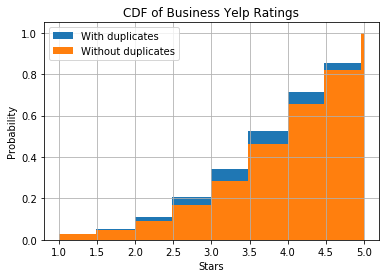

In [135]:
unique_businesses = get_unique_businesses(businesses)
plt.figure();
dfs = unique_businesses['stars'].sort_values();
businesses['stars'].hist(cumulative=True, density=1, bins=100);
dfs.hist(cumulative=True, density=1, bins=100);
plt.xlabel('Stars');
plt.ylabel('Probability');
plt.title('CDF of Business Yelp Ratings');
plt.legend(["With duplicates","Without duplicates"])

Nothing too large changed here, but most of the duplicates seem to have been businessses between 3 and 4.5 stars.[](http://)

In [136]:
unique_businesses = calculate_earliests(unique_businesses, reviews)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [137]:
unique_businesses.dropna(inplace=True)
len(unique_businesses)
#unique_businesses.head()

13593

In [138]:
unique_businesses['lifespan'] = -1
for i, row in unique_businesses.iterrows():
    bid = row['business_id']
    unique_businesses.at[i,'lifespan'] = get_yelp_lifespan(bid)

In [139]:
unique_businesses_lives = unique_businesses[(unique_businesses['lifespan'] != 0) & (unique_businesses['lifespan'] != -1)]
len(unique_businesses_lives)

9892

### Conducting the Survival Analysis

Finally, we have all the data required to produce survival curves at each rating tier. Here, I make CDF's for every star bracket, and look at which rating tier has big lifespan distribution differences. In addition to describing the extent of any potential negative impacts bad Yelp reviews may have on businesses, the resulting data will inform where the rating threshold is drawn for "good ratings" and "bad ratings".

Text(0, 0.5, 'Probability')

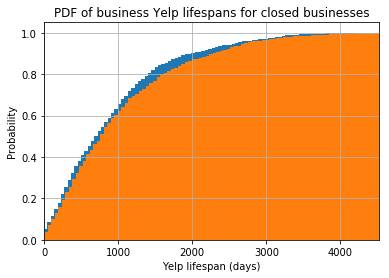

In [140]:
plt.figure()
unique_businesses_lives[(unique_businesses_lives['stars'] >= 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
unique_businesses_lives[(unique_businesses_lives['stars'] < 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
plt.title("PDF of business Yelp lifespans for closed businesses")
plt.xlim((0,min(unique_businesses_lives[(unique_businesses_lives['stars'] >= 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].max(), unique_businesses_lives[(unique_businesses_lives['stars'] < 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].max())))
plt.xlabel("Yelp lifespan (days)")
plt.ylabel("Probability")

For businesses with lifespans between one and three years there does exist a difference in probability of closure. However, this is looking at only businesses that have closed, which may provide a biased view of the data. 

I will repeat this process with all the businesses for which we could calculate lifespans.

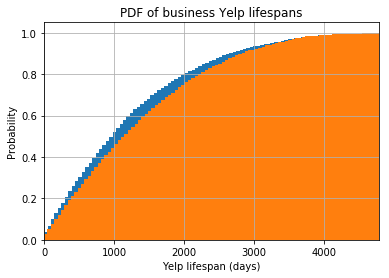

In [141]:
plt.figure()
unique_businesses_lives[(unique_businesses_lives['stars'] >= 4)]['lifespan'].hist(cumulative=True, density=1, bins=100)
unique_businesses_lives[(unique_businesses_lives['stars'] < 4)]['lifespan'].hist(cumulative=True, density=1, bins=100)
plt.title("PDF of business Yelp lifespans")
plt.xlim((0,min(unique_businesses_lives[(unique_businesses_lives['stars'] >= 4)]['lifespan'].max(), unique_businesses_lives[unique_businesses_lives['stars'] < 4]['lifespan'].max())))
plt.xlabel("Yelp lifespan (days)");
plt.ylabel("Probability");

There is little observable difference overall, but there is clearly a range of lifespans during which the probabilities of survival are lower for negatively rated businesses. Because the differences are so small, a CDF will (at least visually speaking) probably help illustrate where this is the case.

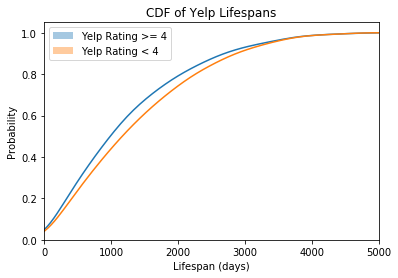

In [142]:
good_rated_lifespans = unique_businesses_lives[(unique_businesses_lives['stars'] >= 4)]['lifespan']
bad_rated_lifespans = unique_businesses_lives[(unique_businesses_lives['stars'] < 4)]['lifespan']
sns.distplot(good_rated_lifespans,kde_kws=dict(cumulative=True),label="Yelp Rating >= 4")
sns.distplot(bad_rated_lifespans,kde_kws=dict(cumulative=True),label="Yelp Rating < 4")
plt.xlim([0,5000])
plt.xlabel("Lifespan (days)")
plt.ylabel("Probability")
plt.title("CDF of Yelp Lifespans")
plt.legend();

Two features of this plot become apparent at first glance: 

1. The maximum difference between the two distributions occurs between 1000 and 2000 days, or between 3 and 5 years.
2. Past 3000 days, there is no discernible difference between the two distributions.

I attempt the above process for each rating tier below:

In [143]:
data_45_5 = unique_businesses_lives[(unique_businesses_lives['stars'] == 5) | (unique_businesses_lives['stars'] == 4.5)]
data_35_4 = unique_businesses_lives[(unique_businesses_lives['stars'] == 4) | (unique_businesses_lives['stars'] == 3.5)]
data_25_3 = unique_businesses_lives[(unique_businesses_lives['stars'] == 3) | (unique_businesses_lives['stars'] == 2.5)]
data_1_15_2 = unique_businesses_lives[(unique_businesses_lives['stars'] <= 2)]
print("len tier 4: " + str(len(data_45_5)))
print("len tier 3: " + str(len(data_35_4)))
print("len tier 2: " + str(len(data_25_3)))
print("len tier 1: " + str(len(data_1_15_2)))

len tier 4: 2961
len tier 3: 4245
len tier 2: 2011
len tier 1: 675


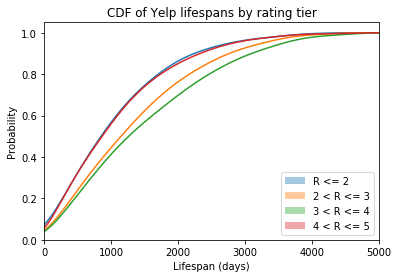

In [144]:
sns.distplot(data_1_15_2['lifespan'],kde_kws=dict(cumulative=True),label="R <= 2")
sns.distplot(data_25_3['lifespan'],kde_kws=dict(cumulative=True),label="2 < R <= 3")
sns.distplot(data_35_4['lifespan'],kde_kws=dict(cumulative=True),label="3 < R <= 4")
sns.distplot(data_45_5['lifespan'],kde_kws=dict(cumulative=True),label="4 < R <= 5")
plt.xlabel("Lifespan (days)")
plt.ylabel("Probability")
plt.title("CDF of Yelp lifespans by rating tier")
plt.xlim([0,5000])
plt.legend();

For the most part, this CDF makes sense, and there is a greater probability of seeing lesser lifespans in lower rating tiers as there is in higher rating tiers.

All 4 distributions appear to be most stratified at that same interval identified earlier ( 1000 < days < 2000 ), but the distribution for the highest tier behaves quite differently than the other tiers, which behave roughly how we would expect them to. 

At about 2600 days, or 7 years, all the rating tier distributions besides the highest tier converge. This suggests that there is actually a higher probability of seeing the highest rated establishments have lower lifespans than the other tiers between lifespans of 2000 and 3200 days.

The data used for this CDF (the distrbution of lifespans), is used along with the state of the business (open/closed) to produce the following survival curve and Kaplan Meier estimation for the highest rating tier.

UPDATE: The data is still right censored, so the survival curves are probably more useful to analyze than this CDF.

Text(0.5, 0, 'Time (days)')

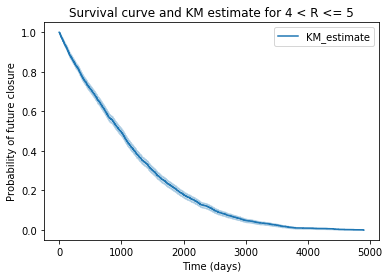

In [145]:
kmf = KaplanMeierFitter()
kmf.fit(data_45_5['lifespan'], data_45_5['is_open'])
kmf.plot()
plt.title("Survival curve and KM estimate for 4 < R <= 5")
plt.ylabel("Probability of future closure")
plt.xlabel("Time (days)")

Putting two survival curves on the same plot could help identify the difference negative reviews could be making. The CDF's from above suggested that while there exists a stratification across all rating tiers, the very highest tier acts differently from the others, so I'll split the highest tier from the others.

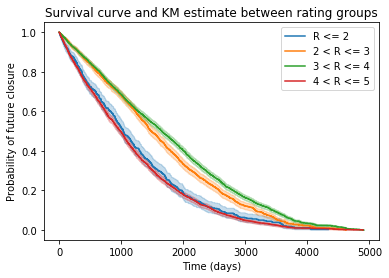

In [146]:
ax = plt.subplot(111)

kmf_1_2 = KaplanMeierFitter()
kmf_25_3 = KaplanMeierFitter()
kmf_35_4 = KaplanMeierFitter()
kmf_45_5 = KaplanMeierFitter()

ax = kmf_1_2.fit(data_1_15_2['lifespan'], data_1_15_2['is_open']).plot(ax=ax,label="R <= 2")
ax = kmf_25_3.fit(data_25_3['lifespan'], data_25_3['is_open']).plot(ax=ax, label="2 < R <= 3")
ax = kmf_35_4.fit(data_35_4['lifespan'], data_35_4['is_open']).plot(ax=ax, label="3 < R <= 4")
ax = kmf_45_5.fit(data_45_5['lifespan'], data_45_5['is_open']).plot(ax=ax, label="4 < R <= 5")


plt.title("Survival curve and KM estimate between rating groups")
plt.ylabel("Probability of future closure")
plt.xlabel("Time (days)")
plt.legend()


The survival curves between the lowest rated businesses and the highest rated businesses appear to be nearly identical. Either this is a really interesting observation, or the data is being analyzed or represented incorrectly. I will make my best effort to verify which of these scenarios is the case.

I will start by isolating the curves in question.

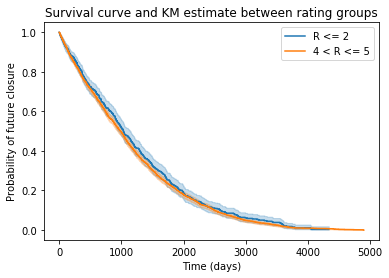

In [147]:
ax = plt.subplot(111)

kmf_1_2 = KaplanMeierFitter()
kmf_45_5 = KaplanMeierFitter()

ax = kmf_1_2.fit(data_1_15_2['lifespan'], data_1_15_2['is_open']).plot(ax=ax,label="R <= 2")
ax = kmf_45_5.fit(data_45_5['lifespan'], data_45_5['is_open']).plot(ax=ax, label="4 < R <= 5")

plt.title("Survival curve and KM estimate between rating groups")
plt.ylabel("Probability of future closure")
plt.xlabel("Time (days)")
plt.legend()

The KM estimation for the highest rating group is almost entirely within the estimation for the lowest tier.

I will check the summary statistics of either tier.

In [148]:
data_1_15_2['stars'].describe()

count    675.000000
mean       1.728148
std        0.365145
min        1.000000
25%        1.500000
50%        2.000000
75%        2.000000
max        2.000000
Name: stars, dtype: float64

In [149]:
data_45_5['stars'].describe()

count    2961.000000
mean        4.701959
std         0.245382
min         4.500000
25%         4.500000
50%         4.500000
75%         5.000000
max         5.000000
Name: stars, dtype: float64

Both datasets are accurate to their tiers. For the 45_5 tier, there are more 4.5's than 5's.

In [150]:
len(data_45_5[data_45_5['stars'] == 4.5]) - len(data_45_5[data_45_5['stars'] == 5])

569

Does the data look any different when the rating tiers are shifted lower by half a rating?

len tier 5: 1196
len tier 3.5: 4245
len tier 2.5: 2011
len tier 1.5: 675


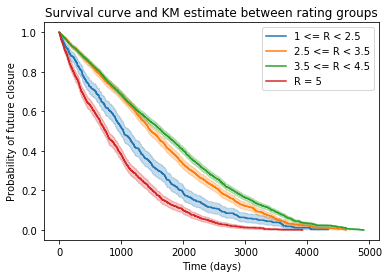

In [152]:
data_5 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 5)]
data_35_45 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 3.5) & (unique_businesses_lives['stars'] < 4.5)]
data_25_35 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 2.5) & (unique_businesses_lives['stars'] < 3.5)]
data_15_25 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 1) & (unique_businesses_lives['stars'] < 2.5)]

print("len tier 5: " + str(len(data_5)))
print("len tier 3.5: " + str(len(data_35_45)))
print("len tier 2.5: " + str(len(data_25_35)))
print("len tier 1.5: " + str(len(data_15_25)))

ax = plt.subplot(111)

kmf_15_25 = KaplanMeierFitter()
kmf_25_35 = KaplanMeierFitter()
kmf_35_45 = KaplanMeierFitter()
kmf_5 = KaplanMeierFitter()

ax = kmf_15_25.fit(data_15_25['lifespan'], data_15_25['is_open']).plot(ax=ax,label="1 <= R < 2.5")
ax = kmf_25_35.fit(data_25_35['lifespan'], data_25_35['is_open']).plot(ax=ax, label="2.5 <= R < 3.5")
ax = kmf_35_45.fit(data_35_45['lifespan'], data_35_45['is_open']).plot(ax=ax, label="3.5 <= R < 4.5")
ax = kmf_5.fit(data_5['lifespan'], data_5['is_open']).plot(ax=ax, label="R = 5")

plt.title("Survival curve and KM estimate between rating groups")
plt.ylabel("Probability of future closure")
plt.xlabel("Time (days)")
plt.legend()


The survival curve for five star restaurants acts as we'd expect it to, but seems to act very differently from its neighboring tier (3.5-4.5). It is beginning to look likely that five star businesses act very differently from businesses that are rated otherwise.

len tier 5: 1196
len tier 4.5: 1765
len tier 4: 2266


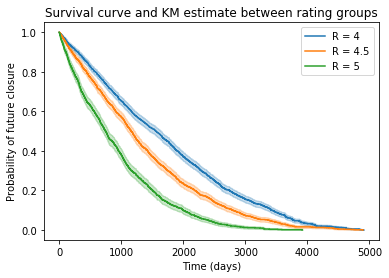

In [160]:
data_5 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 5)]
data_45 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 4.5) & (unique_businesses_lives['stars'] < 5)]
data_4 = unique_businesses_lives[(unique_businesses_lives['stars'] == 4)]

print("len tier 5: " + str(len(data_5)))
print("len tier 4.5: " + str(len(data_45)))
print("len tier 4: " + str(len(data_4)))

ax = plt.subplot(111)

kmf_4 = KaplanMeierFitter()
kmf_45 = KaplanMeierFitter()
kmf_5 = KaplanMeierFitter()

ax = kmf_4.fit(data_4['lifespan'], data_4['is_open']).plot(ax=ax, label="R = 4")
ax = kmf_45.fit(data_45['lifespan'], data_45['is_open']).plot(ax=ax, label="R = 4.5")
ax = kmf_5.fit(data_5['lifespan'], data_5['is_open']).plot(ax=ax, label="R = 5")

plt.title("Survival curve and KM estimate between rating groups")
plt.ylabel("Probability of future closure")
plt.xlabel("Time (days)")
plt.legend()


The difference between neighboring tiers is clearly visualized above. It appears that the highest tier has survival curves within ratings grouped into the tier that are quite different.

Summary statistics for each one:

In [156]:
data_5.describe()

,is_open,review_count,stars,lifespan
count,1196.000000,1196.000000,1196.0,1196.000000
mean,0.919732,23.391304,5.0,841.397157
std,0.271821,65.896247,0.0,717.718222
min,0.000000,3.000000,5.0,1.000000
25%,1.000000,6.000000,5.0,260.500000
50%,1.000000,11.000000,5.0,669.500000
75%,1.000000,23.250000,5.0,1231.250000
max,1.000000,1936.000000,5.0,3918.000000


In [158]:
data_45.describe()

,is_open,review_count,stars,lifespan
count,1765.000000,1765.000000,1765.0,1765.000000
mean,0.865722,58.247025,4.5,1203.296317
std,0.341047,152.069041,0.0,947.094929
min,0.000000,3.000000,4.5,1.000000
25%,1.000000,10.000000,4.5,449.000000
50%,1.000000,20.000000,4.5,1017.000000
75%,1.000000,50.000000,4.5,1718.000000
max,1.000000,3576.000000,4.5,4897.000000


In [159]:
data_4.describe()

,is_open,review_count,stars,lifespan
count,5227.000000,5227.000000,5227.000000,5227.000000
mean,0.853071,58.869332,4.397647,1223.807155
std,0.354069,154.540774,0.393873,996.111061
min,0.000000,3.000000,4.000000,1.000000
25%,1.000000,9.000000,4.000000,427.500000
50%,1.000000,19.000000,4.500000,985.000000
75%,1.000000,49.000000,4.500000,1795.500000
max,1.000000,3576.000000,5.000000,4906.000000


While there are differences in the number of reviews across tiers, they don't seem to be too substantial.

If the ratings within the tiers have survival curves this different, I might have been wrong to group the other tiers together as well. I'll try everything.

len tier 5: 1196
len tier 4.5: 1765
len tier 4: 2266


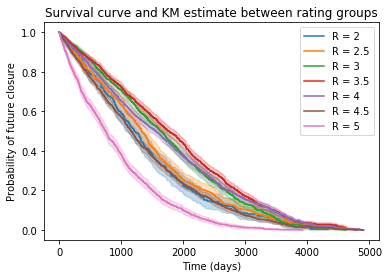

In [161]:
data_5 = unique_businesses_lives[(unique_businesses_lives['stars'] >= 5)]
data_45 = unique_businesses_lives[(unique_businesses_lives['stars'] == 4.5)]
data_4 = unique_businesses_lives[(unique_businesses_lives['stars'] == 4)]
data_35 = unique_businesses_lives[(unique_businesses_lives['stars'] == 3.5)]
data_3 = unique_businesses_lives[(unique_businesses_lives['stars'] == 3)]
data_25 = unique_businesses_lives[(unique_businesses_lives['stars'] == 2.5)]
data_2 = unique_businesses_lives[(unique_businesses_lives['stars'] == 2)]

print("len tier 5: " + str(len(data_5)))
print("len tier 4.5: " + str(len(data_45)))
print("len tier 4: " + str(len(data_4)))

ax = plt.subplot(111)

kmf_2 = KaplanMeierFitter()
kmf_25 = KaplanMeierFitter()
kmf_3 = KaplanMeierFitter()
kmf_35 = KaplanMeierFitter()
kmf_4 = KaplanMeierFitter()
kmf_45 = KaplanMeierFitter()
kmf_5 = KaplanMeierFitter()


ax = kmf_2.fit(data_2['lifespan'], data_2['is_open']).plot(ax=ax, label="R = 2")
ax = kmf_25.fit(data_25['lifespan'], data_25['is_open']).plot(ax=ax, label="R = 2.5")
ax = kmf_3.fit(data_3['lifespan'], data_3['is_open']).plot(ax=ax, label="R = 3")
ax = kmf_35.fit(data_35['lifespan'], data_35['is_open']).plot(ax=ax, label="R = 3.5")
ax = kmf_4.fit(data_4['lifespan'], data_4['is_open']).plot(ax=ax, label="R = 4")
ax = kmf_45.fit(data_45['lifespan'], data_45['is_open']).plot(ax=ax, label="R = 4.5")
ax = kmf_5.fit(data_5['lifespan'], data_5['is_open']).plot(ax=ax, label="R = 5")

plt.title("Survival curve and KM estimate between rating groups")
plt.ylabel("Probability of future closure")
plt.xlabel("Time (days)")
plt.legend()
